In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import textwrap
import seaborn as sns
import openpyxl


Matplotlib is building the font cache; this may take a moment.


#### Plot regression sanity check

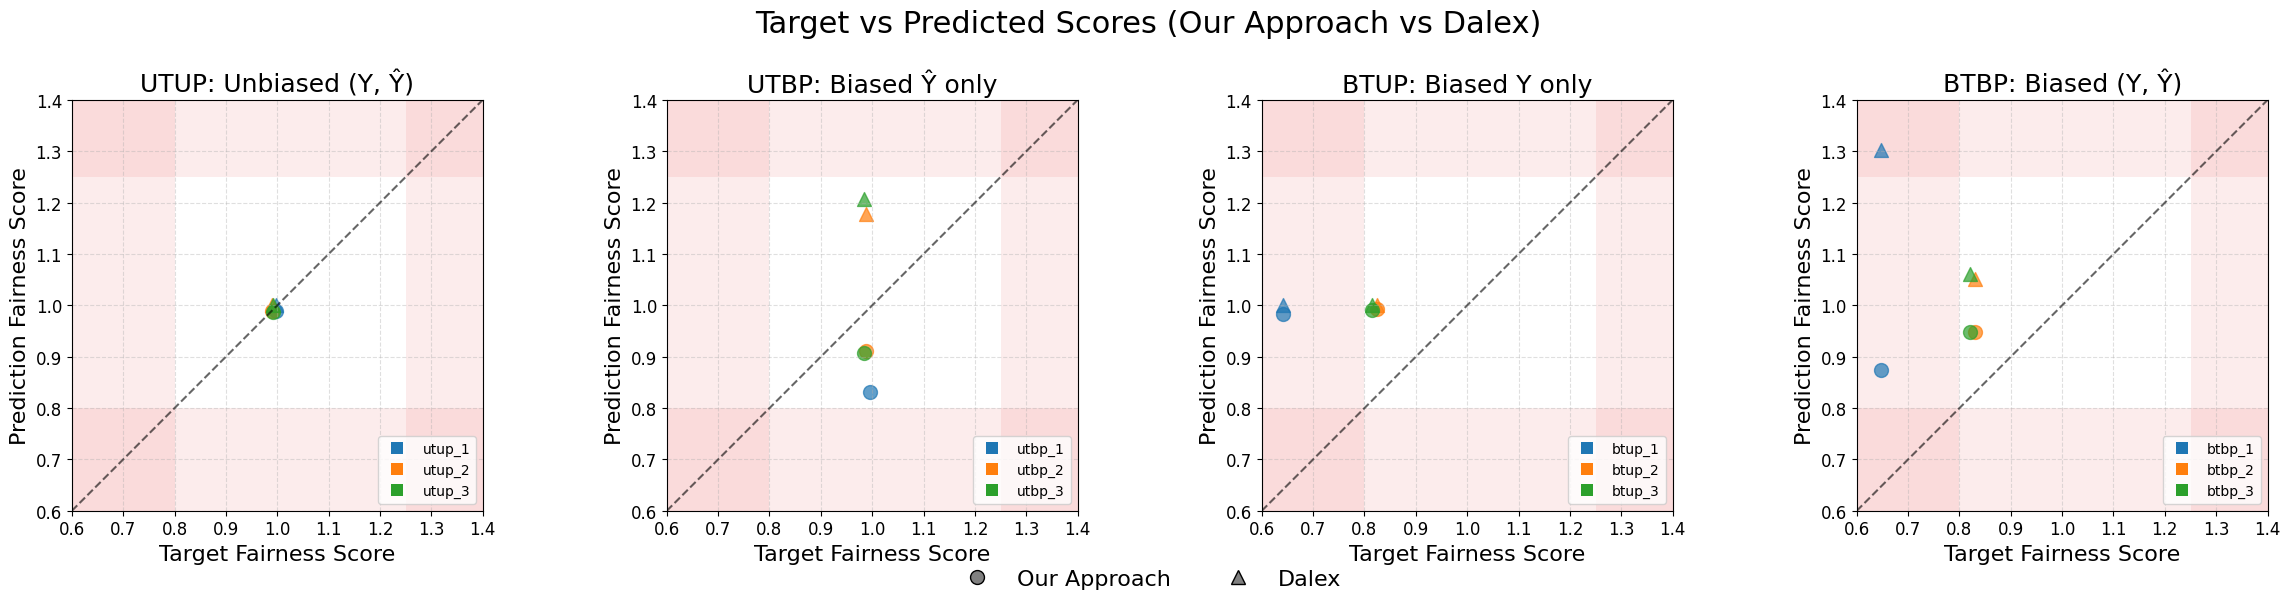

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_excel('../results/regression_simulations.xlsx')
df = df[df['simulation_type'] == 'low_bias_single_cat_equal_distribution']
df1 = df[df['Protected_Feature'] == 'UTUP']
df2 = df[df['Protected_Feature'] == 'UTBP']
df3 = df[df['Protected_Feature'] == 'BTUP']
df4 = df[df['Protected_Feature'] == 'BTBP']


def plot_fairness_scatter(ax, df, title):

    # consistent axis limits + aspect
    ax.set_xlim(0.6, 1.4)
    ax.set_ylim(0.6, 1.4)

    # --------------------------------------------
    # CATEGORY COLORS (consistent across ALL plots)
    # --------------------------------------------
    all_categories = sorted(df['Protected_Class'].unique())
    palette = plt.cm.tab10.colors
    category_colors = {cat: palette[i % len(palette)] for i, cat in enumerate(all_categories)}

    # plot
    for cat in all_categories:
        sub = df[df["Protected_Class"] == cat]
        col = category_colors[cat]

        # Our method
        ax.scatter(sub["FairAI_target"], sub["FairAI_pred"],
                   color=col, alpha=0.7, s=100, marker='o')

        # Dalex
        ax.scatter(sub["FairAI_target"], sub["dalex_pred"],
                   color=col, alpha=0.7, s=100, marker='^')

    # 45-degree reference line
    ax.plot([0.6, 1.4], [0.6, 1.4], 'k--', alpha=0.6)

    # fairness shading
    ax.axhspan(0.6, 0.8, facecolor='lightcoral', alpha=0.15, zorder=0)
    ax.axhspan(1.25, 1.4, facecolor='lightcoral', alpha=0.15, zorder=0)
    ax.axvspan(0.6, 0.8, facecolor='lightcoral', alpha=0.15, zorder=0)
    ax.axvspan(1.25, 1.4, facecolor='lightcoral', alpha=0.15, zorder=0)

    # cosmetics
    ax.set_xlabel("Target Fairness Score", fontsize=16)
    ax.set_ylabel("Prediction Fairness Score", fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.4)

    # --------------------------
    # CATEGORY LEGEND (INSIDE)
    # --------------------------
    cat_handles = [
        Line2D([0], [0], marker='s', linestyle='none',
               markersize=8, markerfacecolor=category_colors[cat], markeredgewidth=0, 
               label=cat)
        for cat in all_categories
    ]

    ax.legend(handles=cat_handles,
              loc='lower right',
              fontsize=10, title_fontsize=14)
    ax.tick_params(axis='both', labelsize=12)



# ------------- Global layout -------------
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=False)

plot_fairness_scatter(axes[0], df1, "UTUP: Unbiased (Y, Ŷ)")
plot_fairness_scatter(axes[1], df2, "UTBP: Biased Ŷ only")
plot_fairness_scatter(axes[2], df3, "BTUP: Biased Y only")
plot_fairness_scatter(axes[3], df4, "BTBP: Biased (Y, Ŷ)")

# -----------------------------------------
# OUTER LEGEND (METHODS)
# -----------------------------------------
method_handles = [
    Line2D([0], [0], marker='o', linestyle='none',
           markersize=10, markerfacecolor='grey', markeredgecolor='black',
           label='Our Approach'),
    Line2D([0], [0], marker='^', linestyle='none',
           markersize=10, markerfacecolor='grey', markeredgecolor='black',
           label='Dalex'),
]

fig.legend(handles=method_handles, loc='lower center',
           ncol=2, fontsize=16, frameon=False,
           bbox_to_anchor=(0.5, -0.02))

fig.suptitle("Target vs Predicted Scores (Our Approach vs Dalex)", fontsize=22)
plt.subplots_adjust(left=0.07, right=0.95, wspace=0.25, bottom=0.20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.show()


#### Plot regression results

In [48]:
def enrich_df(df, feature_dict, category_description=None):

    df["bias"] = 0            # start with all 0s

    # Filter subset where feature matches substring
    for feature_substring, rows_to_set_1 in feature_dict.items():
        mask = df["Protected_Feature"].str.contains(feature_substring, case=False, na=False)
        subset_idx = df[mask].index

        # Convert 1-based row positions to actual indices in df
        rows_to_set_1_zero_based = [i-1 for i in rows_to_set_1]  # convert 1→0-based
        target_indices = subset_idx[rows_to_set_1_zero_based]

        # Set bias = 1 only for those subset rows
        df.loc[target_indices, "bias"] = 1
    if category_description:
        df["feature_description"] = df["Protected_Feature"].map(category_description)
        df = df.drop(columns=["Protected_Feature"])
        df = df.rename(columns={"feature_description": "Protected_Feature"})
    return df

df = pd.read_excel('../results/regression_simulations.xlsx')
df4 = df[(df['simulation_type'] == 'high_bias_multiple_cats_unequal_distribution') & (df['Protected_Feature'].str.contains('BTBP'))]
df5 = df[(df['simulation_type'] == 'high_bias_multiple_cats_unequal_distribution_poor_model') & (df['Protected_Feature'].str.contains('BTBP'))]
df2 = df[(df['simulation_type'] == 'high_bias_single_cat_equal_distribution') & (df['Protected_Feature'])]
df3 = df[(df['simulation_type'] == 'high_bias_single_cat_unequal_distribution') & (df['Protected_Feature'])]
df1 = df[(df['simulation_type'] == 'low_bias_single_cat_equal_distribution') & (df['Protected_Feature'])]

category_description = {
    "BTBP_ML_O": "Med & low prev. cat. biased in opp. dir",
    "BTBP_ML_S": "Med & low prev. cat. biased in same dir",
    "BTBP_MH_O": "Med & high prev. cat. biased in opp. dir",
    "BTBP_MH_S": "Med & high prev. cat. biased in same dir",
    "BTBP_LH_O": "Low & high prev. cat. biased in opp. dir",
    "BTBP_LH_S": "Low & high prev. cat. biased in same dir",
    "BTBP_MM_O": "Both med prev. cat. biased in opp. dir",
    "BTBP_MM_S": "Both med prev. cat. biased in same dir"
}

feature_dict = {
    "BTBP_ML_O": [1, 4],
    "BTBP_ML_S": [1, 4],
    "BTBP_MH_O": [1, 3],
    "BTBP_MH_S": [1, 3],
    "BTBP_LH_O": [3, 4],
    "BTBP_LH_S": [3, 4],
    "BTBP_MM_O": [1, 2],
    "BTBP_MM_S": [1, 2]
}

df4 = enrich_df(df4, feature_dict, category_description)
df5 = enrich_df(df5, feature_dict, category_description)

feature_dict = {
    "UTUP": [],
    "UTBP": [1],
    "BTUP": [],
    "BTBP": [1]
}
df1 = enrich_df(df1, feature_dict)
df2 = enrich_df(df2, feature_dict)
df3 = enrich_df(df3, feature_dict)



C:\Users\Arushi Jain\AppData\Local\Temp\ipykernel_28872\1965924005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bias"] = 0            # start with all 0s
C:\Users\Arushi Jain\AppData\Local\Temp\ipykernel_28872\1965924005.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["feature_description"] = df["Protected_Feature"].map(category_description)
C:\Users\Arushi Jain\AppData\Local\Temp\ipykernel_28872\1965924005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [72]:

def plot_fairness_dots(ax, df, *, wrap_chars=8, xlim=None, legend_loc="upper right"):
    """
    Horizontal dot plot:
      - Left: Protected_Feature labels
      - Right: Protected_Class tick labels
      - Two dots per row: FairAI_pred (o) and dalex_pred (^)
      - Color: red if bias=1 else blue
      - Shading: left of 0.8 and right of 1.25
    """
    df_plot = df[::-1].copy()

    levels = df_plot["Protected_Feature"].astype(str).unique()
    categories = df_plot["Protected_Class"].astype(str).unique()

    # Spacing
    level_spacing = 1.0
    category_spacing = 0.8

    # Build positions
    pos_map = {}
    y_positions = []
    level_centers = []
    current_y = 0.0

    for lvl in levels:
        lvl_cats = df_plot.loc[df_plot["Protected_Feature"] == lvl, "Protected_Class"].astype(str).unique()
        level_start_y = current_y
        for cat in lvl_cats:
            pos_map[(lvl, cat)] = current_y
            y_positions.append(current_y)
            current_y += category_spacing
        level_center = level_start_y + (len(lvl_cats) - 1) * category_spacing / 2.0
        level_centers.append((lvl, level_center))
        if lvl != levels[-1]:
            current_y += level_spacing

    # ---- Plot points ----
    for _, row in df_plot.iterrows():
        lvl = str(row['Protected_Feature'])
        cat = str(row['Protected_Class'])
        y = pos_map[(lvl, cat)]
        color = "red" if int(row.get("bias", 0)) == 1 else "blue"
        ax.scatter(row['FairAI_pred'], y, color=color, alpha=0.85, s=50, marker='o')
        ax.scatter(row['dalex_pred'], y, color=color, alpha=0.85, s=50, marker='^')

    # ---- Right-side category tick labels ----
    tick_positions = [pos_map[(str(r['Protected_Feature']), str(r['Protected_Class']))] for _, r in df_plot.iterrows()]
    tick_labels = [str(r['Protected_Class']) for _, r in df_plot.iterrows()]
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels)
    ax.tick_params(axis='y', labelright=True, labelleft=False)
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')

    # ---- Left-side feature labels ----
    for lvl, y_ctr in level_centers:
        words = str(lvl).split()
        lines = [" ".join(words[i:i+4]) for i in range(0, len(words), 5)]
        txt = "\n".join(lines)

        ax.text(-0.005, y_ctr, txt,
                transform=ax.get_yaxis_transform(),
                ha='right', va='center',
                fontsize=10, linespacing=1.0, wrap=True,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.85, pad=1),
                clip_on=False)

    # ---- X limits ----
    if xlim is None:
        xmin = float(pd.concat([df_plot['FairAI_pred'], df_plot['dalex_pred']]).min())
        xmax = float(pd.concat([df_plot['FairAI_pred'], df_plot['dalex_pred']]).max())
        pad = 0.02 * (xmax - xmin if xmax > xmin else 1.0)
        ax.set_xlim(xmin - pad, xmax + pad)
    else:
        ax.set_xlim(*xlim)

    # ---- Shaded regions ----
    x_min, x_max = ax.get_xlim()
    ax.axvspan(x_min, 0.8, color='lightcoral', alpha=0.1, zorder=0)
    ax.axvspan(1.25, x_max, color='lightcoral', alpha=0.1, zorder=0)

    # ---- Y limits ----
    if y_positions:
        ax.set_ylim(min(y_positions) - 0.6, max(y_positions) + 0.6)

    # ---- Cosmetics ----
    ax.set_xlabel("Prediction Fairness Score", fontsize=12)
    ax.grid(True, axis='x', linestyle='--', alpha=0.35)

    # ---- Legends ----
    h1 = plt.Line2D([], [], color='black', marker='o', linestyle='None', label='FairAI')
    h2 = plt.Line2D([], [], color='black', marker='^', linestyle='None', label='DALEX')
    h3 = plt.Line2D([], [], color='blue', marker='s', linestyle='None', label='Unbiased Category')
    h4 = plt.Line2D([], [], color='red', marker='s', linestyle='None', label='Biased Category')

    ax.legend(handles=[h1, h2, h3, h4],
              frameon=True, facecolor='white', framealpha=0.85,
              loc=legend_loc, fontsize=12)


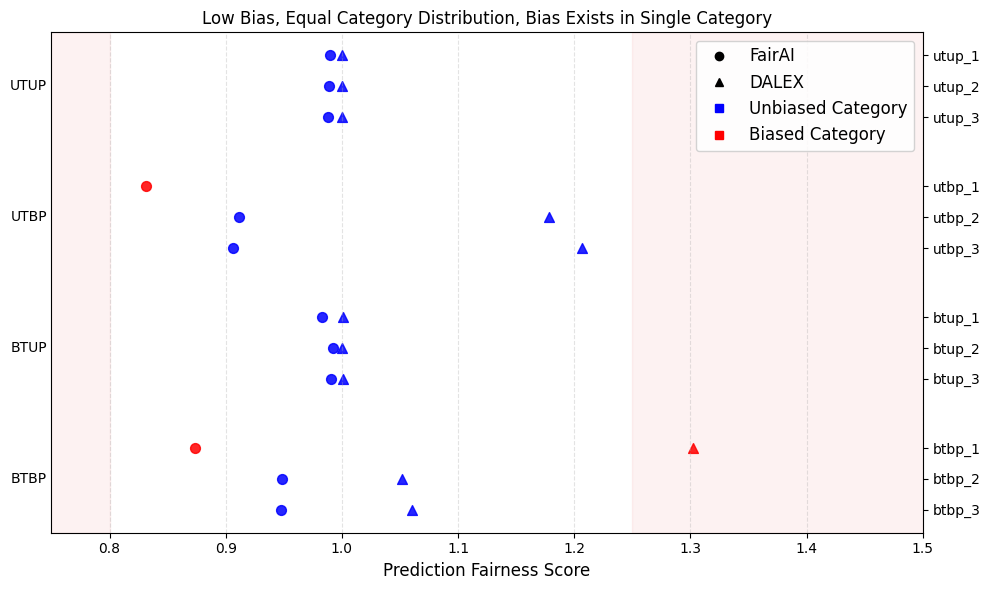

In [73]:
# ---------- Usage ----------
fig, ax = plt.subplots(figsize=(10, 6))
plot_fairness_dots(ax, df1, wrap_chars=8)  # optionally xlim=(0.4, 1.0)
ax.set_xlim(0.75,1.5)
ax.set_title("Low Bias, Equal Category Distribution, Bias Exists in Single Category", fontsize=12)
plt.tight_layout()
plt.show()

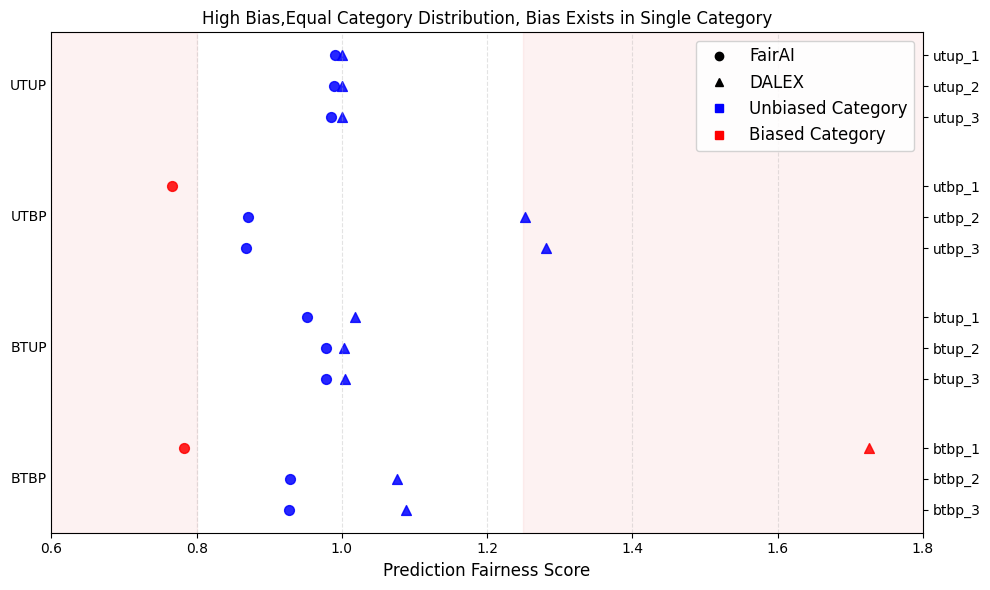

In [74]:
# ---------- Usage ----------
fig, ax = plt.subplots(figsize=(10, 6))
plot_fairness_dots(ax, df2, wrap_chars=8)  # optionally xlim=(0.4, 1.0)
ax.set_xlim(0.6,1.8)
ax.set_title("High Bias,Equal Category Distribution, Bias Exists in Single Category", fontsize=12)
plt.tight_layout()
plt.show()

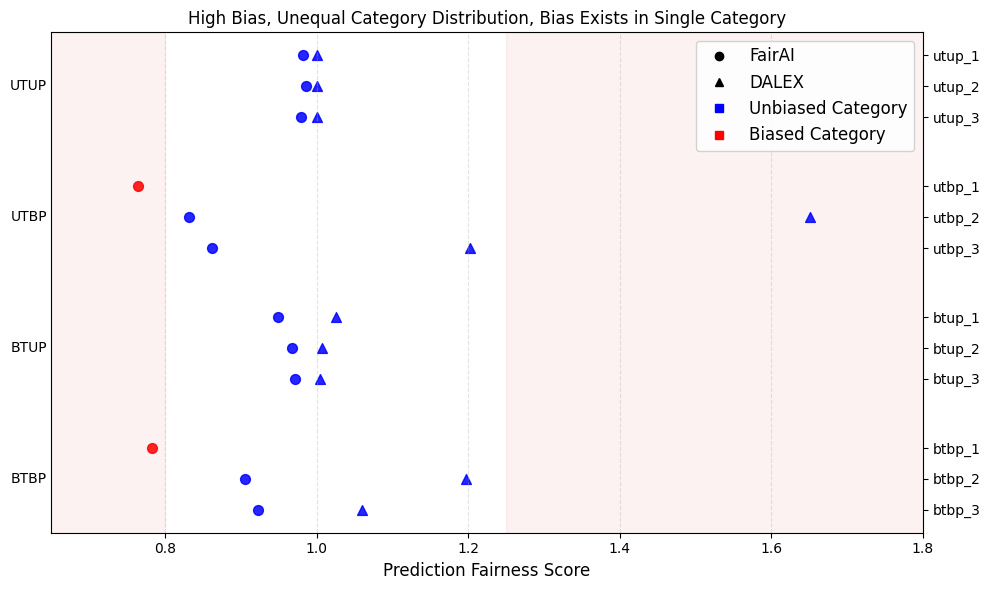

In [75]:
# ---------- Usage ----------
fig, ax = plt.subplots(figsize=(10, 6))
plot_fairness_dots(ax, df3, wrap_chars=8)  # optionally xlim=(0.4, 1.0)
ax.set_xlim(0.65,1.8)
ax.set_title("High Bias, Unequal Category Distribution, Bias Exists in Single Category", fontsize=12)
plt.tight_layout()
plt.show()

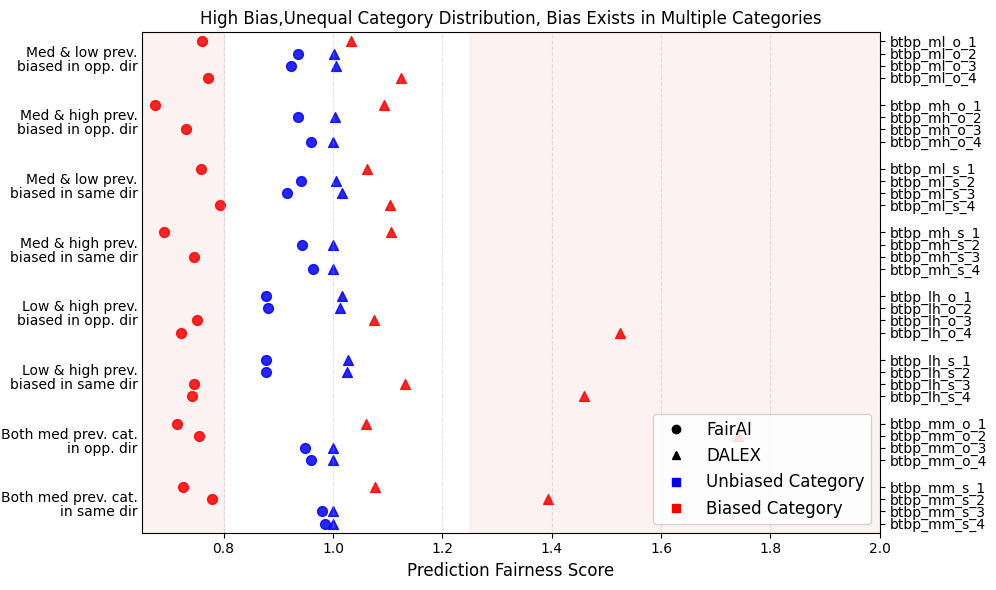

In [76]:
# ---------- Usage ----------
fig, ax = plt.subplots(figsize=(10, 6))
plot_fairness_dots(ax, df4, wrap_chars=8, legend_loc="lower right")  # optionally xlim=(0.4, 1.0)
ax.set_xlim(0.65,2)
ax.set_title("High Bias,Unequal Category Distribution, Bias Exists in Multiple Categories", fontsize=12)
plt.tight_layout()
plt.show()

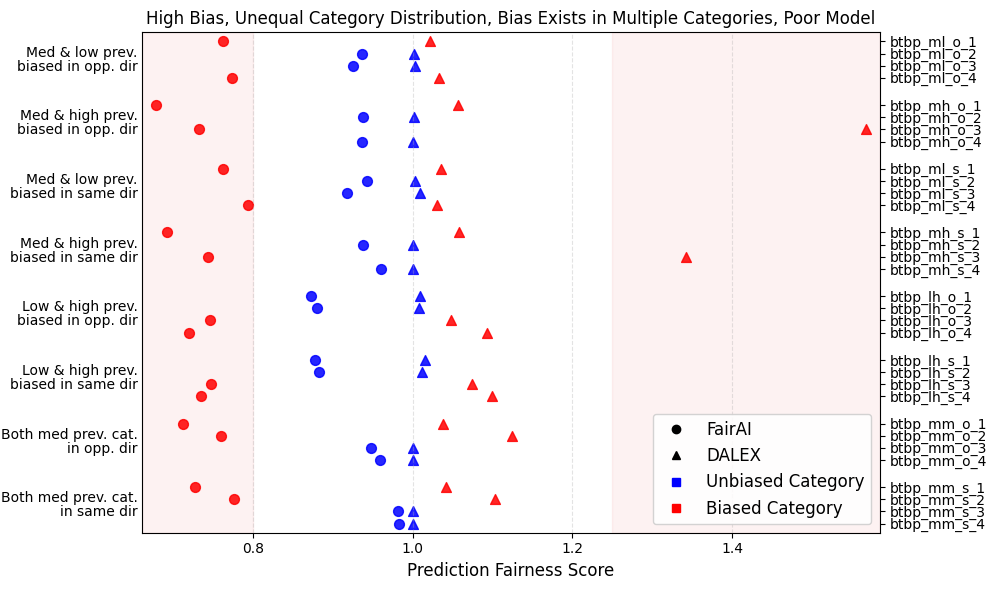

In [77]:
# ---------- Usage ----------
fig, ax = plt.subplots(figsize=(10, 6))
plot_fairness_dots(ax, df5, wrap_chars=8, legend_loc="lower right")  # optionally xlim=(0.4, 1.0)
ax.set_title("High Bias, Unequal Category Distribution, Bias Exists in Multiple Categories, Poor Model", fontsize=12)
plt.tight_layout()
plt.show()

#### Plot classification results

In [139]:
def add_category_description(df):
    category_description = {
        "high_bias_single_cat_equal_distribution_classification": "Equal Category Distr.",
        "high_bias_single_cat_unequal_distribution_classification": "Unequal Category Distr.",
        "high_bias_single_cat_equal_distribution_classification_poor_model": "Equal Category Distr., Poor Model",
    }
    df["category_description"] = df["simulation_type"].map(category_description)
    df = df.drop(columns=["simulation_type"])
    df = df.rename(columns={"category_description": "simulation_type"})
    return df


def wrap_every_n_words(s, n=1):
    words = str(s).split()
    return "\n".join(" ".join(words[i:i+n]) for i in range(0, len(words), n))

def plot_grouped_heatmap(
    df, *,
    cmap="RdYlGn",
    level_gap_height=0.3,   # <<< fractional visual gap between level blocks (in row units)
    figsize=(10, 6),
    annot_fmt=".2f",
    col_gap_width=0.1
):
    """
    df columns: simulation_type (level), Protected_Class (category),
                fairness_class_0, fairness_class_1, fairness_class_2, FairAI_pred

    - Rows: (level, category) with a *fractional* visual gap between levels
    - Cols: fairness_class_0, fairness_class_1, fairness_class_2 | FairAI_pred
            (thin visual separator + slim white band between groups)
    - Left: wrapped level labels; Right: category labels
    - Cells display values
    """


    # columns
    pred_cols_left  = ["fairness_class_0", "fairness_class_1", "fairness_class_2"]
    pred_cols_right = ["FairAI_pred"]
    all_cols = pred_cols_left + pred_cols_right

    # build matrix without inserting NaN gap rows
    df = df.copy()
    df["simulation_type"] = df["simulation_type"].astype(str)
    df["Protected_Class"] = df["Protected_Class"].astype(str)

    levels = df["simulation_type"].dropna().unique().tolist()

    rows = []
    level_block_ranges = []   # (level, start_row_index, end_row_index) in matrix coords
    row_values = []

    row_idx = 0
    for lvl in levels:
        sub = df[df["simulation_type"] == lvl]
        cats = sub["Protected_Class"].tolist()  # keep order in df
        start_idx = row_idx
        for cat in cats:
            rows.append((lvl, cat))
            row_df = sub[sub["Protected_Class"] == cat].iloc[0]
            row_values.append([row_df[c] for c in all_cols])
            row_idx += 1
        end_idx = row_idx - 1
        level_block_ranges.append((lvl, start_idx, end_idx))

    data = np.array(row_values, dtype=float)

    # plot
    fig, ax = plt.subplots(figsize=figsize)

    cmap_obj = plt.get_cmap(cmap).copy()
    cmap_obj.set_bad(color="white")
    norm = mcolors.Normalize(vmin=0.65, vmax=0.95)

    im = ax.imshow(
        data, aspect="auto", interpolation="nearest",
        cmap=cmap_obj, norm=norm
    )

    # colorbar (keep clear of right y-axis labels)
    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.10)
    cbar.set_label("Score")

    # x ticks (rename nicely)
    xticks = np.arange(len(all_cols))
    ax.set_xticks(xticks)
    ax.set_xticklabels(["Class 0", "Class 1", "Class 2", "Overall"])
    ax.set_xlabel("Fairness Scores", fontsize=12)

    # right-side y ticks (categories)
    cat_tick_positions, cat_tick_labels = [], []
    for i, (lvl, cat) in enumerate(rows):
        cat_tick_positions.append(i)
        cat_tick_labels.append(cat)
    ax.set_yticks(cat_tick_positions)
    ax.set_yticklabels(cat_tick_labels, fontsize=12)
    ax.tick_params(axis="y", labelright=True, labelleft=False, labelsize=12)
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_label_position("right")

    # left-side level labels (wrapped & centered)
    for lvl, start_i, end_i in level_block_ranges:
        center = (start_i + end_i) / 2.0
        txt = wrap_every_n_words(lvl, n=1)
        ax.text(
            -0.02, center, txt,
            transform=ax.get_yaxis_transform(),  # x in axes, y in data
            ha="right", va="center",
            fontsize=9, linespacing=1.0, wrap=True,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=1.5),
            clip_on=False
        )

    # thin visual separator + slim white band between column groups
    sep_center = len(pred_cols_left) - 0.5
    if col_gap_width and col_gap_width > 0:
        gap_left = sep_center - col_gap_width / 2.0
        rect = Rectangle(
            (gap_left, -0.5),
            width=col_gap_width,
            height=data.shape[0],
            facecolor="white", edgecolor="none", alpha=1.0, zorder=1
        )
        ax.add_patch(rect)

    # >>> fractional ROW gaps between level blocks (drawn, not added to data)
    if level_gap_height and level_gap_height > 0:
        n_rows = data.shape[0]
        for _, _, end_i in level_block_ranges[:-1]:
            # center the gap around the boundary between end_i and end_i+1 (at y = end_i + 0.5)
            y0 = (end_i + 0.5) - level_gap_height / 2.0
            rect = Rectangle(
                (-0.5, y0),
                width=data.shape[1],            # span all columns
                height=level_gap_height,        # fractional height in row units
                facecolor="white", edgecolor="none", alpha=1.0, zorder=1.5
            )
            ax.add_patch(rect)
            # optional subtle dotted line over the gap:

    # annotate cell values
    n_rows, n_cols = data.shape
    for i in range(n_rows):
        for j in range(n_cols):
            val = data[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:{annot_fmt}}",
                        ha="center", va="center",
                        color="black", fontsize=10, zorder=3)

    ax.set_title("Class-wise and Overall Fairness Scores for Multiclass Usecase", fontsize=14)

    fig.subplots_adjust(right=0.86)
    plt.tight_layout()
    plt.show()


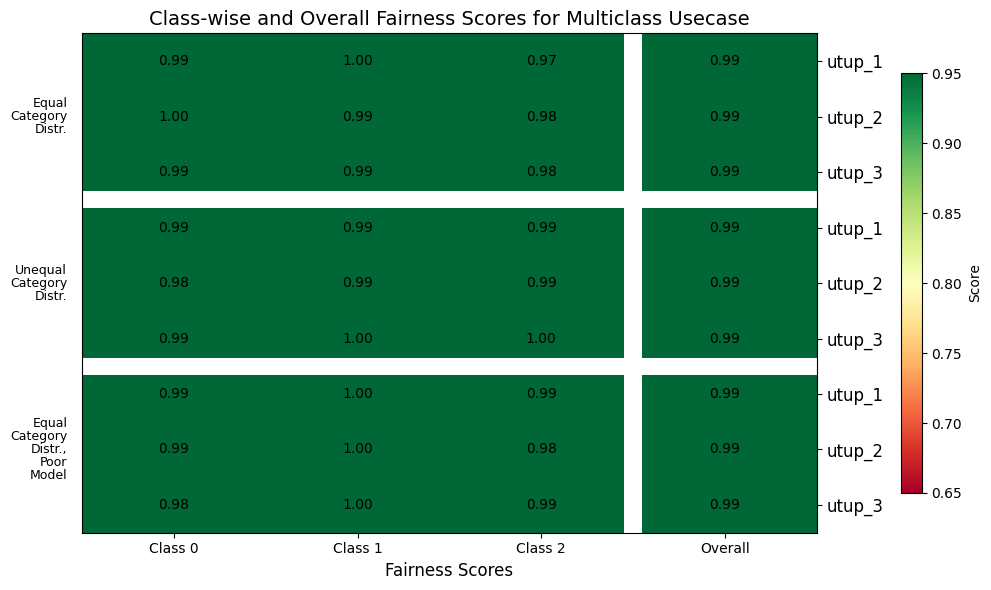

In [140]:
df = pd.read_excel('../results/classification_simulations.xlsx')
df = add_category_description(df)
df = df[df['Protected_Feature'] == 'UTUP']
plot_grouped_heatmap(df)

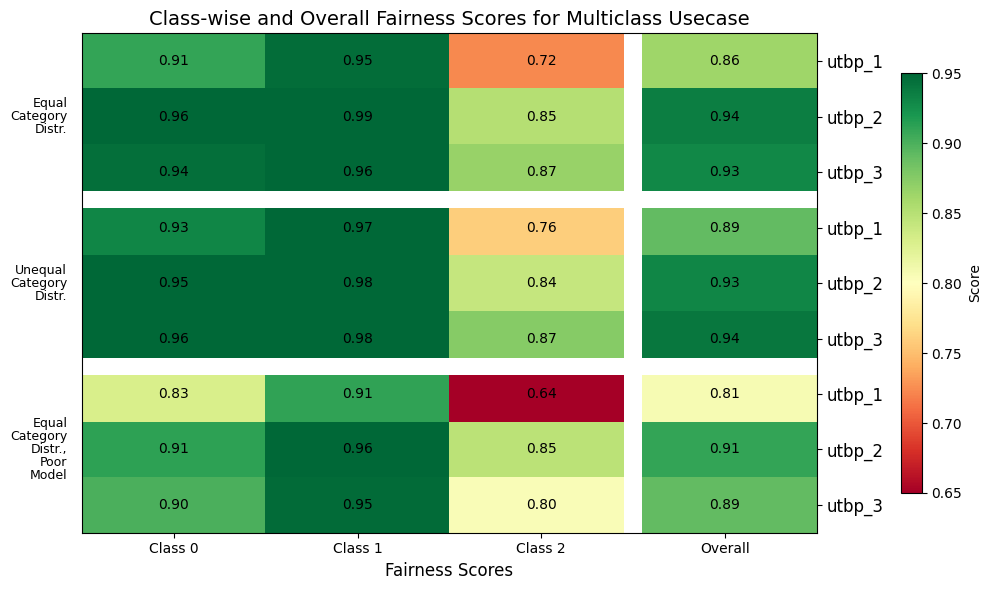

In [141]:
df = pd.read_excel('../results/classification_simulations.xlsx')
df = add_category_description(df)
df = df[df['Protected_Feature'] == 'UTBP']
plot_grouped_heatmap(df)

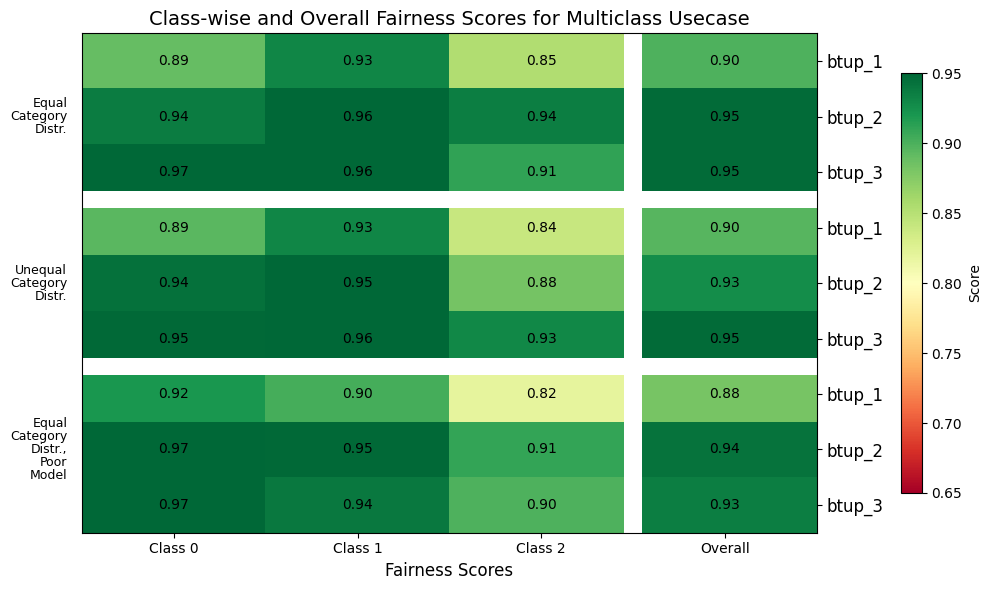

In [142]:
df = pd.read_excel('../results/classification_simulations.xlsx')
df = add_category_description(df)
df = df[df['Protected_Feature'] == 'BTUP']
plot_grouped_heatmap(df)

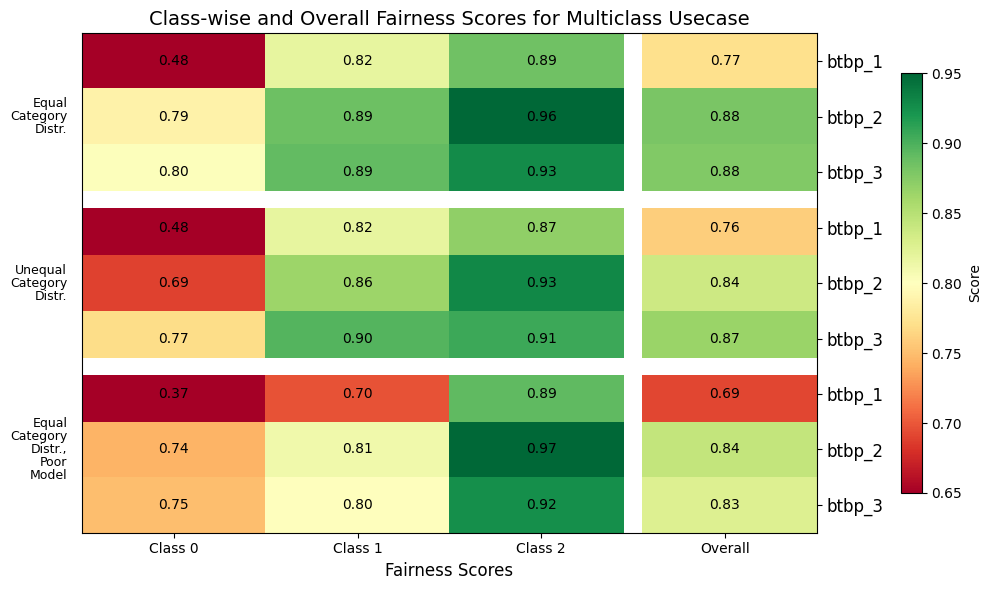

In [143]:
df = pd.read_excel('../results/classification_simulations.xlsx')
df = add_category_description(df)
df = df[df['Protected_Feature'] == 'BTBP']
plot_grouped_heatmap(df)

#### Plot ablations

In [38]:
# -------------------- Helper to plot one panel (mirrors your "correct code") --------------------
def plot_panel(ax, df, *, show_right_ticks=False, wrap_chars=8, xlim=(0.4, 1.0)):
    # -------------------- Shared color mapping (categories common across all 3) --------------------
    ALL_CATS = list(df['Protected_Class'].unique())
    base_colors = ['red', 'blue', 'blue']  # your palette idea
    COLOR_LIST = (base_colors * ((len(ALL_CATS) + len(base_colors) - 1) // len(base_colors)))[:len(ALL_CATS)]
    CATEGORY_COLORS = {cat: COLOR_LIST[i] for i, cat in enumerate(ALL_CATS)}
        # Sort for stable grouping (your reverse)
    df_plot = df[::-1].copy()

    levels = df_plot["level"].unique()
    categories = df_plot["Protected_Class"].unique()

    # ----- compute positions (present categories per level only)
    level_spacing = 1.0
    category_spacing = 0.8

    pos_map = {}
    y_positions = []
    level_centers = []

    current_y = 0.0
    for lvl in levels:
        lvl_cats = df_plot.loc[df_plot["level"] == lvl, "Protected_Class"].unique()
        level_start_y = current_y
        for cat in lvl_cats:
            pos_map[(lvl, cat)] = current_y
            y_positions.append(current_y)
            current_y += category_spacing
        # center of this level
        level_center = level_start_y + (len(lvl_cats) - 1) * category_spacing / 2.0
        level_centers.append((lvl, level_center))
        if lvl != levels[-1]:
            current_y += level_spacing

    # ----- colors (use shared mapping so categories look the same across panels)
    category_colors = {cat: CATEGORY_COLORS.get(cat, 'gray') for cat in categories}

    # ----- plot bars
    for _, row in df_plot.iterrows():
        lvl = row['level']
        cat = row['Protected_Class']
        mean_val = float(row['FairAI_pred_mean'])
        se_val = float(row['FairAI_pred_se']) * 1.96
        y_pos = pos_map[(lvl, cat)]

        ax.barh(y_pos, mean_val, height=0.6,
                color=category_colors.get(cat, 'gray'),
                alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.errorbar(mean_val, y_pos, xerr=se_val,
                    fmt='none', color='black', capsize=3, capthick=1)

    # ----- category ticks (RIGHT side only for the last subplot)
    if show_right_ticks:
        tick_positions = [pos_map[(row['level'], row['Protected_Class'])] for _, row in df_plot.iterrows()]
        tick_labels = [row['Protected_Class'] for _, row in df_plot.iterrows()]
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels, fontsize=10)
        ax.tick_params(axis='y', labelright=True, labelleft=False, labelsize=10)
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_label_position('right')
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])

    # ----- level labels (wrapped + centered) on LEFT for every subplot
    for lvl, y_ctr in level_centers:
        raw = str(lvl).replace(",", ",\n")        # break line after commas
        txt = textwrap.fill(raw, width=wrap_chars)  # still wrap long phrases if needed

        ax.text(-0.005, y_ctr, txt,
                transform=ax.get_yaxis_transform(),
                ha='right', va='center',
                fontsize=10, linespacing=1.1, wrap=True,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.85, pad=2))

    # ----- cosmetics / limits
    ax.set_xlabel('Fairness Score', fontsize=12)
    ax.axvline(x=0.8, color='black', linestyle=':', linewidth=2, alpha=0.8)
    ax.set_xlim(*xlim)
    if y_positions:
        ax.set_ylim(min(y_positions) - 0.6, max(y_positions) + 0.6)

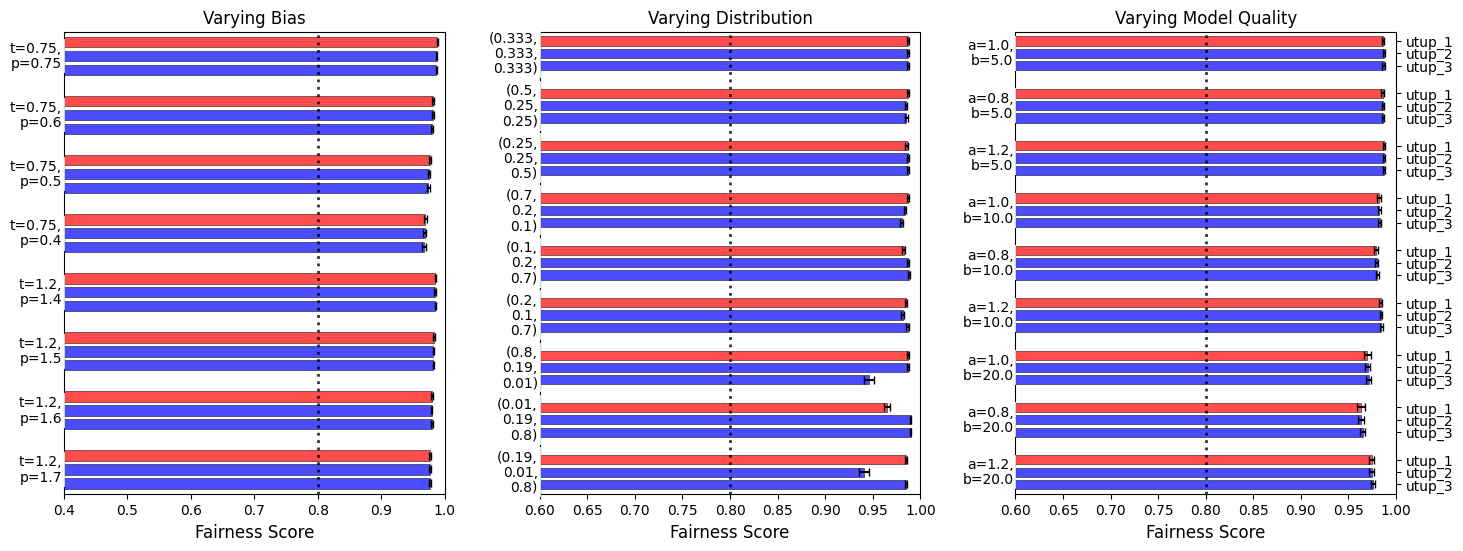

In [39]:
df = pd.read_excel('../results/reg_ablation.xlsx')
df = df[df['Protected_Feature'] == 'UTUP']

df1 = df[df['ablation'] == 'vary_bias'][3:]
df2 = df[df['ablation'] == 'vary_distribution']
df3 = df[df['ablation'] == 'vary_model']

# -------------------- Build the 1x3 layout --------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

plot_panel(axes[0], df1, show_right_ticks=False, xlim=(0.4, 1))
axes[0].set_title('Varying Bias', fontsize=12)

plot_panel(axes[1], df2, show_right_ticks=False, xlim=(0.6, 1))
axes[1].set_title('Varying Distribution', fontsize=12)

# Only last subplot shows the shared RIGHT y-axis (categories)
plot_panel(axes[2], df3, show_right_ticks=True, xlim=(0.6, 1))
axes[2].set_title('Varying Model Quality', fontsize=12)

# Room for left labels across all three and the right labels on the last
fig.subplots_adjust(left=0.14, right=0.88, wspace=0.25)
plt.show()


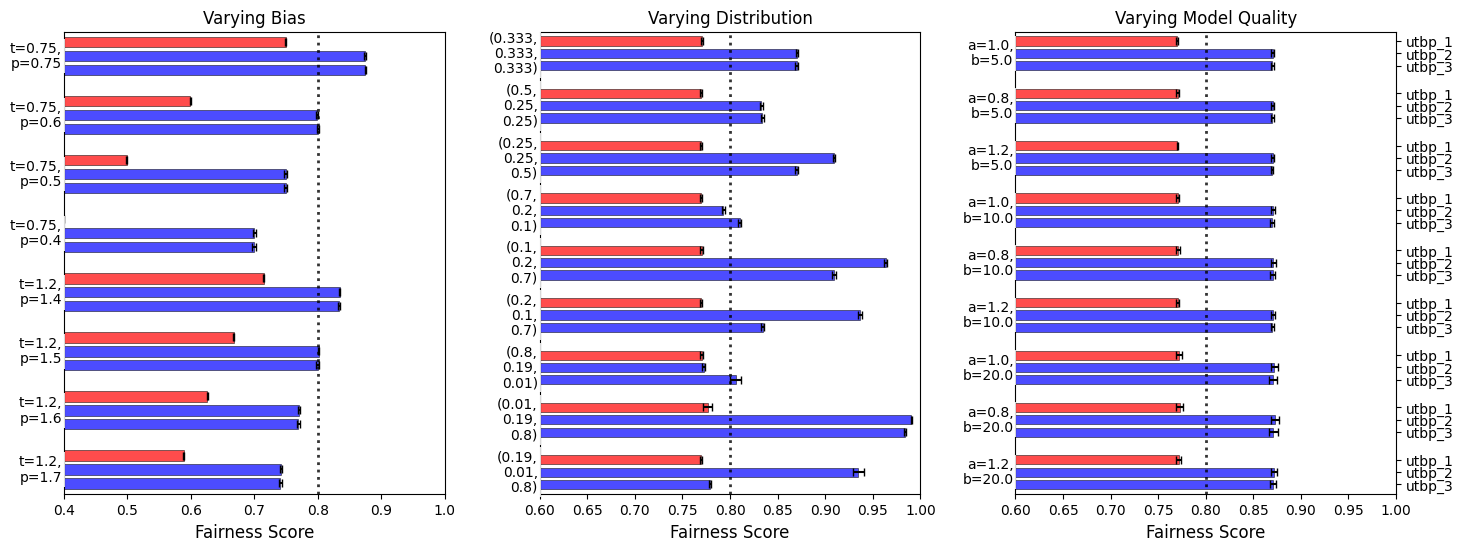

In [40]:
df = pd.read_excel('../results/reg_ablation.xlsx')
df = df[df['Protected_Feature'] == 'UTBP']

df1 = df[df['ablation'] == 'vary_bias'][3:]
df2 = df[df['ablation'] == 'vary_distribution']
df3 = df[df['ablation'] == 'vary_model']

# -------------------- Build the 1x3 layout --------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

plot_panel(axes[0], df1, show_right_ticks=False, xlim=(0.4, 1))
axes[0].set_title('Varying Bias', fontsize=12)

plot_panel(axes[1], df2, show_right_ticks=False, xlim=(0.6, 1))
axes[1].set_title('Varying Distribution', fontsize=12)

# Only last subplot shows the shared RIGHT y-axis (categories)
plot_panel(axes[2], df3, show_right_ticks=True, xlim=(0.6, 1))
axes[2].set_title('Varying Model Quality', fontsize=12)

# Room for left labels across all three and the right labels on the last
fig.subplots_adjust(left=0.14, right=0.88, wspace=0.25)
plt.show()


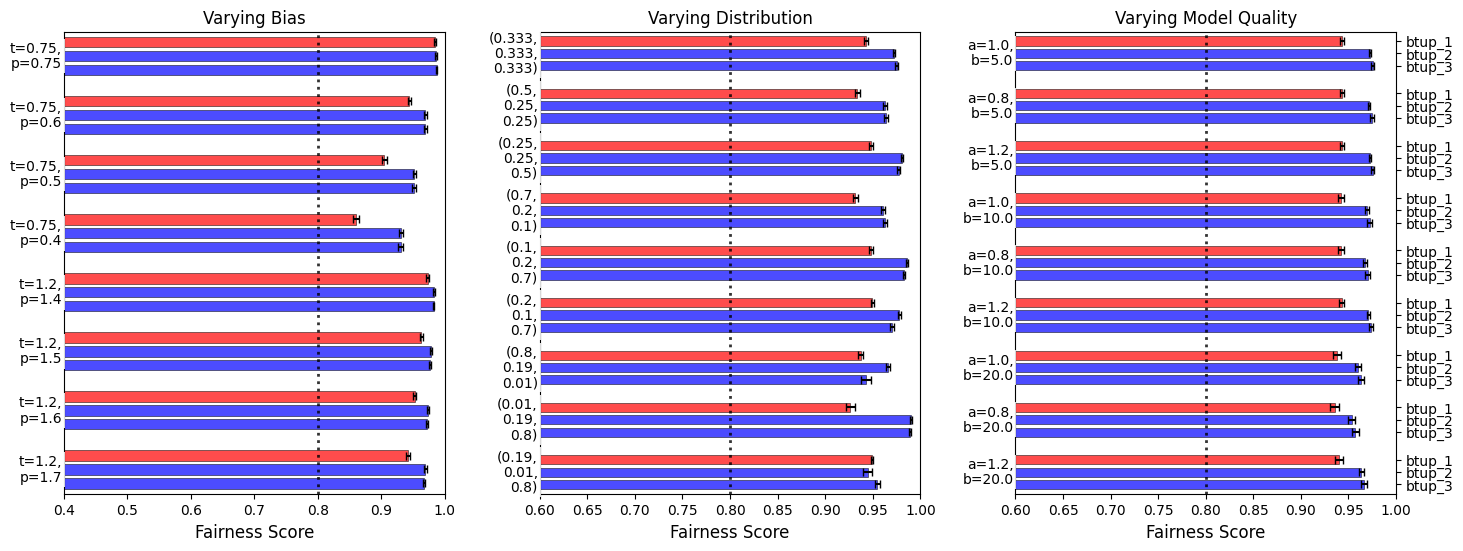

In [41]:
df = pd.read_excel('../results/reg_ablation.xlsx')
df = df[df['Protected_Feature'] == 'BTUP']

df1 = df[df['ablation'] == 'vary_bias'][3:]
df2 = df[df['ablation'] == 'vary_distribution']
df3 = df[df['ablation'] == 'vary_model']

# -------------------- Build the 1x3 layout --------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

plot_panel(axes[0], df1, show_right_ticks=False, xlim=(0.4, 1))
axes[0].set_title('Varying Bias', fontsize=12)

plot_panel(axes[1], df2, show_right_ticks=False, xlim=(0.6, 1))
axes[1].set_title('Varying Distribution', fontsize=12)

# Only last subplot shows the shared RIGHT y-axis (categories)
plot_panel(axes[2], df3, show_right_ticks=True, xlim=(0.6, 1))
axes[2].set_title('Varying Model Quality', fontsize=12)

# Room for left labels across all three and the right labels on the last
fig.subplots_adjust(left=0.14, right=0.88, wspace=0.25)
plt.show()


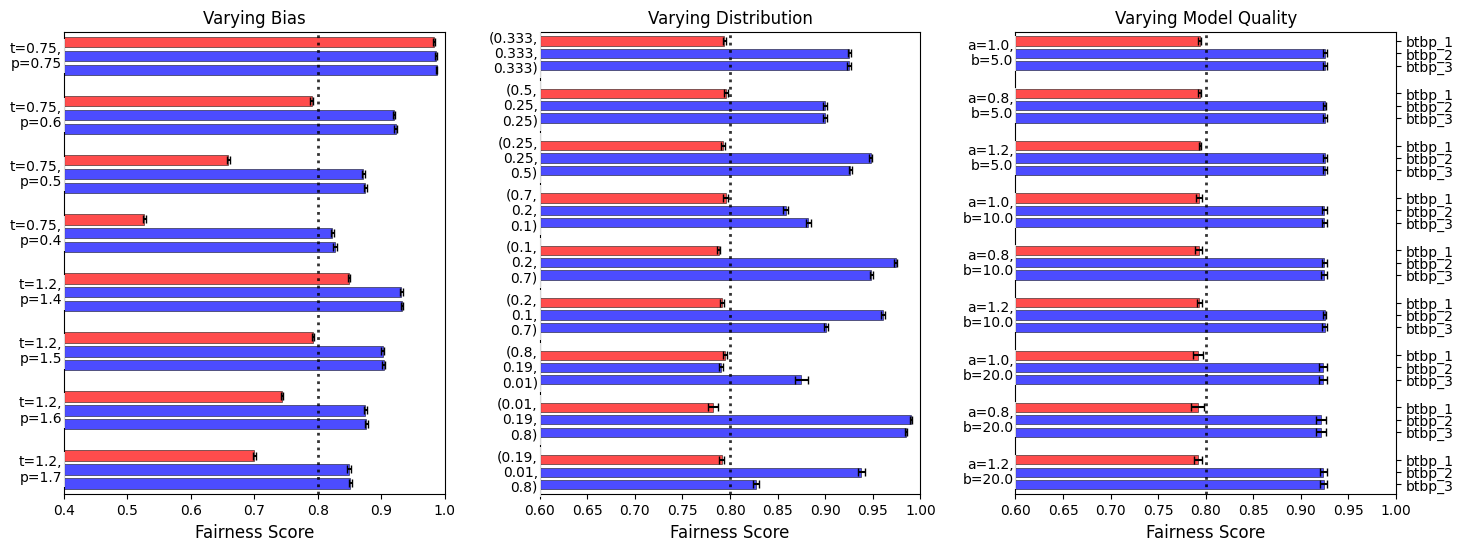

In [42]:
df = pd.read_excel('../results/reg_ablation.xlsx')
df = df[df['Protected_Feature'] == 'BTBP']

df1 = df[df['ablation'] == 'vary_bias'][3:]
df2 = df[df['ablation'] == 'vary_distribution']
df3 = df[df['ablation'] == 'vary_model']

# -------------------- Build the 1x3 layout --------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

plot_panel(axes[0], df1, show_right_ticks=False, xlim=(0.4, 1))
axes[0].set_title('Varying Bias', fontsize=12)

plot_panel(axes[1], df2, show_right_ticks=False, xlim=(0.6, 1))
axes[1].set_title('Varying Distribution', fontsize=12)

# Only last subplot shows the shared RIGHT y-axis (categories)
plot_panel(axes[2], df3, show_right_ticks=True, xlim=(0.6, 1))
axes[2].set_title('Varying Model Quality', fontsize=12)

# Room for left labels across all three and the right labels on the last
fig.subplots_adjust(left=0.14, right=0.88, wspace=0.25)
plt.show()
